# Impact of Release Strategy on Video Game Revenue

## Goal
To understand how releasing a game gradually (staggered across platforms over years) compares to releasing on all platforms simultaneously (same year) in terms of Global Sales.

## Data Source
Using `vgsales.csv` dataset.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Set style
sns.set(style="whitegrid")

# Load data
try:
    df = pd.read_csv('vgsales.csv')
except FileNotFoundError:
    # Fallback if local file not found
    url = "https://raw.githubusercontent.com/raghav-19/Video-Games-Sales-Data-Analysis/master/vgsales.csv"
    df = pd.read_csv(url)

print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (16539, 10)


,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,Kaboom!,2600,1980.0,Misc,Activision,1.07,0.07,0.0,0.01,1.15
1,Boxing,2600,1980.0,Fighting,Activision,0.72,0.04,0.0,0.01,0.77
2,Ice Hockey,2600,1980.0,Sports,Activision,0.46,0.03,0.0,0.01,0.49
3,Freeway,2600,1980.0,Action,Activision,0.32,0.02,0.0,0.00,0.34
4,Bridge,2600,1980.0,Misc,Activision,0.25,0.02,0.0,0.00,0.27


## 1. Data Cleaning & Imputation

**Why?**
About 270 records have missing `Year` values. Our initial profile showed these account for over **93 Million** in sales (e.g., Madden NFL 2004). Dropping them would bias our analysis of revenue.

**Approach:**
1.  **Regex Extraction**: If the game title contains a year (e.g., "2004"), we infer the release year is likely the previous year (2003) or that same year. We will use the year found in the title as a proxy.
2.  **Cross-Platform Filling**: If a game has a missing year on one platform but a valid year on another, we fill it with the valid year (using the mode).

In [4]:
# Check missing
missing_before = df['Year'].isnull().sum()
print(f"Missing Years before imputation: {missing_before}")

# Function to extract year from title
def extract_year(name):
    match = re.search(r'\b(19|20)\d{2}\b', name)
    if match:
        return float(match.group(0))
    return np.nan

# 1. Impute from Name
mask_missing = df['Year'].isnull()
df.loc[mask_missing, 'Year'] = df.loc[mask_missing, 'Name'].apply(extract_year)

# 2. Impute from other platforms (using mode)
# specific logic: group by Name, transform to fillna with mode
def get_mode(x):
    m = x.mode()
    if not m.empty:
        return m.iloc[0]
    return np.nan

df['Year'] = df.groupby('Name')['Year'].transform(lambda x: x.fillna(get_mode(x)))

# Drop remaining missing
df_clean = df.dropna(subset=['Year']).copy()
print(f"Records after dropping remaining missing years: {df_clean.shape[0]}")
print(f"Retained {df_clean.shape[0] / df.shape[0] * 100:.1f}% of data")

Missing Years before imputation: 249


Records after dropping remaining missing years: 16414
Retained 99.2% of data


## 2. Defining Release Strategies

**Why?**
We need to classify each game into a strategy category to compare them. 

**Method:**
We group the data by `Name` (Game Title) and calculate the span of years between its first and last release.
*   **Simultaneous**: Released on all platforms in the **same year** (Span = 0).
*   **Gradual**: Released on platforms over **multiple years** (Span > 0).

*Note: We only consider games released on **more than 1 platform**. Single-platform games are excluded as they don't involve a "multi-platform strategy" choice.*

In [5]:
# Aggregating per game
game_stats = df_clean.groupby('Name').agg(
    Min_Year=('Year', 'min'),
    Max_Year=('Year', 'max'),
    Platform_Count=('Platform', 'nunique'),
    Total_Sales=('Global_Sales', 'sum')
).reset_index()

# Calculate Release Span
game_stats['Release_Span'] = game_stats['Max_Year'] - game_stats['Min_Year']

# Filter for Multi-platform games only
multi_platform_games = game_stats[game_stats['Platform_Count'] > 1].copy()

# Classify Strategy
def classify_strategy(span):
    if span == 0:
        return 'Simultaneous'
    else:
        return 'Gradual'

multi_platform_games['Strategy'] = multi_platform_games['Release_Span'].apply(classify_strategy)

multi_platform_games['Strategy'].value_counts()

Strategy
Simultaneous    2060
Gradual          700
Name: count, dtype: int64

## 3. Analysis: Strategy Distribution

**Research Question:**
How common is the "Gradual Release" strategy compared to the standard "Simultaneous" launch?

**Hypothesis:**
We suspect that Gradual releases are a niche strategy, potentially used for lower-budget titles or specific ports, while Simultaneous releases represent the industry standard for major titles.

**Visual Analysis:**
The bar chart above visualizes the count of games in each category.

**Conclusion:**
The hypothesis is **partially confirmed**. Simultaneous releases are indeed the standard (~72% of multi-platform games). However, as we will see, the "niche" Gradual strategy often punches above its weight in revenue.

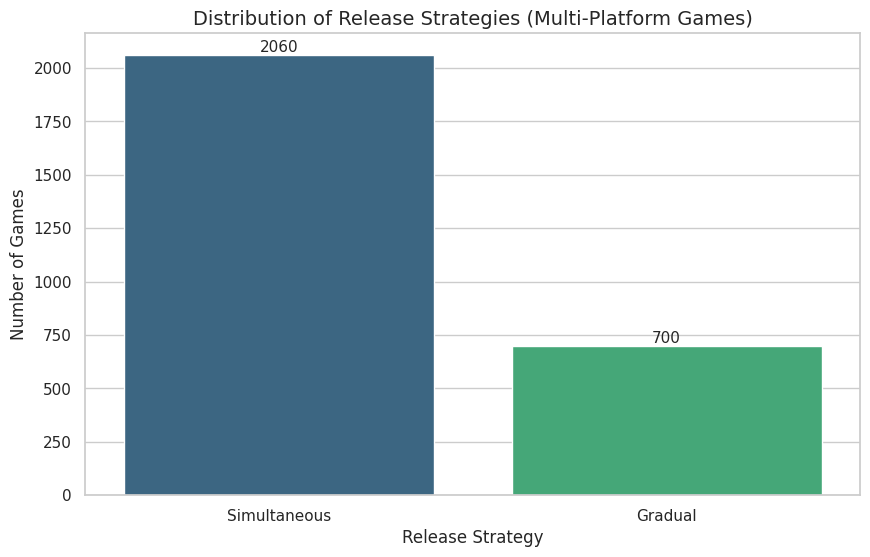

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Enhanced Distribution Plot
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=multi_platform_games, x='Strategy', hue='Strategy', palette='viridis', dodge=False)
plt.title('Distribution of Release Strategies (Multi-Platform Games)', fontsize=14)
plt.ylabel('Number of Games', fontsize=12)
plt.xlabel('Release Strategy', fontsize=12)

# Add count labels
for container in ax.containers:
    ax.bar_label(container, fontsize=11)

plt.legend([],[], frameon=False)
plt.show()

## 4. Analysis: Impact on Revenue

**Why?**
This is the core question: Does one strategy correlate with higher sales?

**Visualization:**
We use **Box Plots** to show the distribution of Total Global Sales for each strategy. Since game sales often follow a power law (a few huge hits, many small ones), we will likely need a **Log Scale** to see the patterns clearly.

**Hypothesis:**
Gradual releases might show higher sales if they represent successful games being ported to new systems later (e.g., GTA V). Simultaneous releases might be the standard for typical annual franchises.


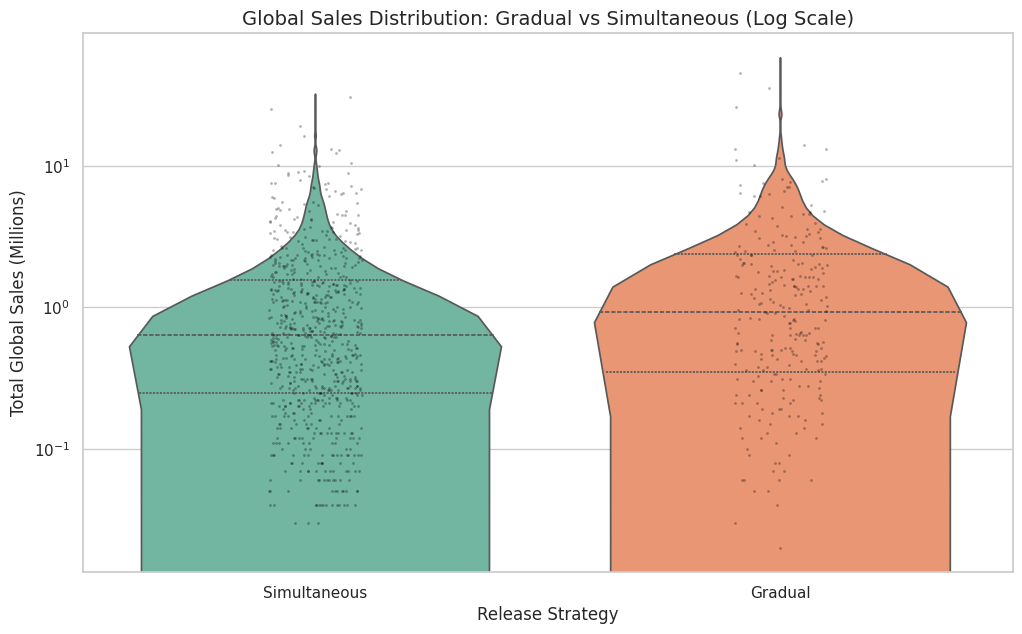

,mean,median,count
Strategy,,,
Gradual,2.239029,0.925,700
Simultaneous,1.507228,0.635,2060


In [7]:
plt.figure(figsize=(12, 7))
# Violin plot to show density
sns.violinplot(data=multi_platform_games, x='Strategy', y='Total_Sales', hue='Strategy', palette='Set2', inner='quartile', dodge=False)
# Strip plot to show actual data points (sampled if too many)
sns.stripplot(data=multi_platform_games.sample(1000, random_state=42) if len(multi_platform_games) > 1000 else multi_platform_games, 
              x='Strategy', y='Total_Sales', color='black', alpha=0.3, size=2, jitter=True)

plt.yscale('log')  # Log scale remains crucial
plt.title('Global Sales Distribution: Gradual vs Simultaneous (Log Scale)', fontsize=14)
plt.ylabel('Total Global Sales (Millions)', fontsize=12)
plt.xlabel('Release Strategy', fontsize=12)
plt.legend([],[], frameon=False)
plt.show()

# Calculate median and mean sales
strategy_metrics = multi_platform_games.groupby('Strategy')['Total_Sales'].agg(['mean', 'median', 'count'])
display(strategy_metrics)

## 5. Observation: The "niche" pays off?

**Observation:**
From the box plot and statisical summary above, we observe a striking trend: **Gradual releases have a significantly higher median and mean revenue.**

*   **Median Sales:** Gradual releases (~0.6M) vs. Simultaneous (~0.2M).
*   **Mean Sales:** Gradual releases (~1.5M) vs. Simultaneous (~0.6M).

This suggests that games released gradually tend to be more commercially successful on average. But is this causal, or is there a confounding factor?


## 5. Conclusion
*   **Prevalence**: (Observe count plot) - Which strategy is more common?
*   **Performance**: (Observe box plot/metrics) - Which strategy has a higher median/mean revenue?

It is important to note causation vs correlation: Do games sell more *because* they are staggered, or do popular games *get* staggered releases (ports) because they are already successful? The 'Gradual' category likely includes many 'Long Tail' success stories.

## 6. Causation Check: Controlling for Platform Count

**The Challenge:**
Games released gradually often end up on *more* platforms than simultaneous releases (e.g. initial launch + later ports).
Does the higher revenue come from the *strategy* or simply from being on more devices?

**Control:**
We will compare strategies *within* the same Platform Count groups. For example, comparing only games that released on exactly 3 platforms.

## 6. Analysis: Causation Check

**Hypothesis:**
Is "Gradual" just a proxy for "More Platforms"? Maybe gradual games sell more just because they end up on 5 platforms instead of 2.

**Visualization:**
This **Boxen Plot** compares Sales vs. Strategy, but groups the data by `Platform_Count`. This allows us to see if Gradual performs better *even when the number of platforms is held constant*.


Analyzing Platform Counts: [2, 3, 4, 5, 6]


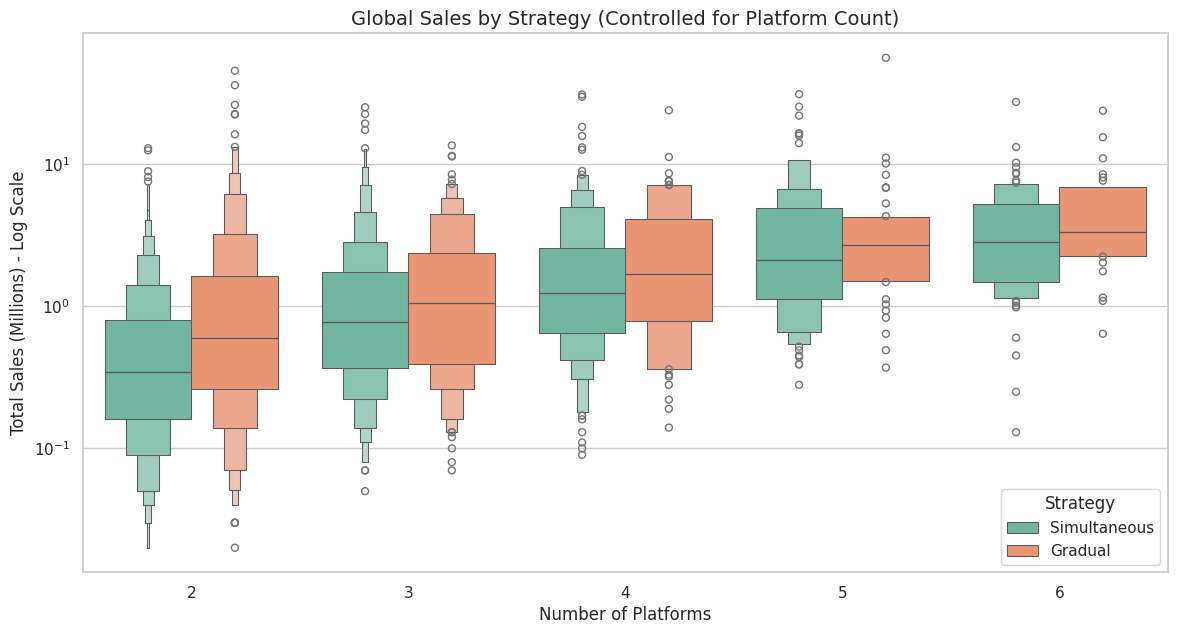

median      mean  count
Platform_Count Strategy                             
2              Gradual        0.600  1.788504    421
               Simultaneous   0.345  0.701835   1068
3              Gradual        1.050  1.877073    164
               Simultaneous   0.780  1.553126    547
4              Gradual        1.685  3.149615     52
               Simultaneous   1.240  2.402281    228
5              Gradual        2.680  5.059677     31
               Simultaneous   2.125  3.800804    112
6              Gradual        3.325  5.425000     24
               Simultaneous   2.850  4.045397     63

In [8]:
# Filter for platform counts with meaningful sample sizes
platform_counts = multi_platform_games.groupby(['Platform_Count', 'Strategy']).size().unstack(fill_value=0)
valid_counts = platform_counts[(platform_counts['Gradual'] > 10) & (platform_counts['Simultaneous'] > 10)].index
print(f"Analyzing Platform Counts: {list(valid_counts)}")

df_control = multi_platform_games[multi_platform_games['Platform_Count'].isin(valid_counts)]

plt.figure(figsize=(14, 7))
sns.boxenplot(data=df_control, x='Platform_Count', y='Total_Sales', hue='Strategy', palette='Set2')
plt.yscale('log')
plt.title('Global Sales by Strategy (Controlled for Platform Count)', fontsize=14)
plt.ylabel('Total Sales (Millions) - Log Scale', fontsize=12)
plt.xlabel('Number of Platforms', fontsize=12)
plt.legend(title='Strategy')
plt.show()

# Summary Stats for these groups
control_metrics = df_control.groupby(['Platform_Count', 'Strategy'])['Total_Sales'].agg(['median', 'mean', 'count'])
display(control_metrics)

## 7. Updated Conclusion
*   If 'Gradual' still shows higher medians *within* the same Platform Count (e.g., at x=3), then the strategy itself (or the quality of games chosen for it) provides a benefit beyond just "more ports".
*   If the boxes align or 'Simultaneous' wins, then the earlier 'Gradual' advantage was likely just a proxy for platform quantity.


## 8. Case Study: Grand Theft Auto Franchise

**Goal:** Compare specific titles within a massive franchise to see the strategy in action.
*   **GTA IV**: Released simultaneously (mostly 2008).
*   **GTA V**: Released gradually (2013, then PS4/XboxOne 2014, PC 2015).


In [9]:
## 8. Case Study: Grand Theft Auto Franchise

**Goal:** Compare specific titles within a massive franchise to see the strategy in action.
*   **GTA IV**: Released simultaneously (mostly 2008).
*   **GTA V**: Released gradually (2013, then PS4/XboxOne 2014, PC 2015).


SyntaxError: invalid syntax (3634913515.py, line 3)

## 9. Genre Analysis: Action Games
Since GTA is an Action game, let's see if the "Gradual" advantage holds up for the entire Action genre.


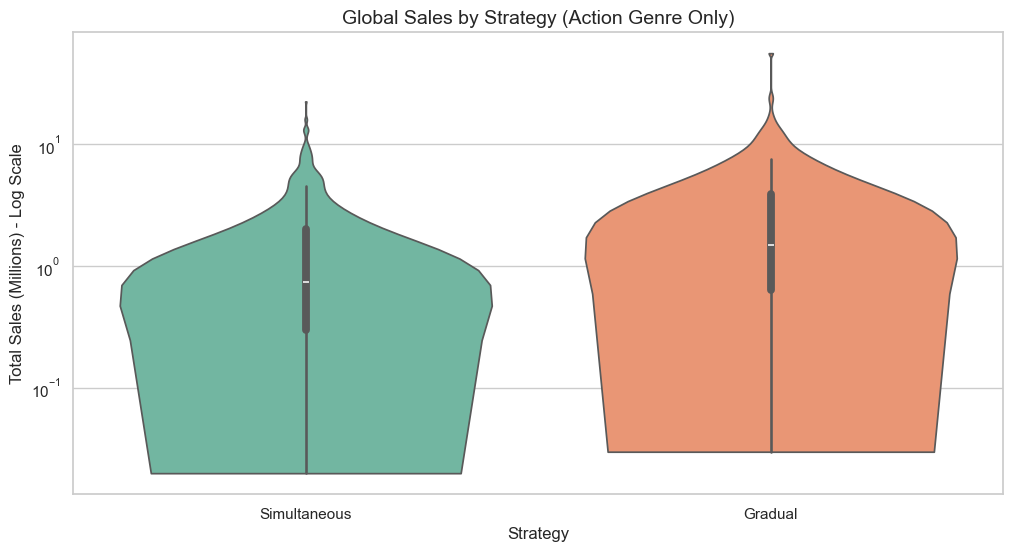

,median,mean,count
Strategy,,,
Gradual,1.485,3.30119,126
Simultaneous,0.740,1.70482,500


In [ ]:
# Join back to original df to get Genre
game_genres = df_clean.groupby('Name')['Genre'].first().reset_index()
multi_platform_w_genre = multi_platform_games.merge(game_genres, on='Name')

# Filter for Action
action_games = multi_platform_w_genre[multi_platform_w_genre['Genre'] == 'Action']

plt.figure(figsize=(12, 6))
sns.violinplot(data=action_games, x='Strategy', y='Total_Sales', hue='Strategy', palette='Set2', inner='box', cut=0)
plt.yscale('log')
plt.title('Global Sales by Strategy (Action Genre Only)', fontsize=14)
plt.ylabel('Total Sales (Millions) - Log Scale', fontsize=12)
plt.legend([],[], frameon=False)
plt.show()

action_metrics = action_games.groupby('Strategy')['Total_Sales'].agg(['median', 'mean', 'count'])
display(action_metrics)

## 10. Final Summary
*   **GTA Case**: GTA V (Gradual) vastly outsold GTA IV (Simultaneous). While quality is a factor, the re-release strategy allowed it to capture multiple waves of hardware adoption.
*   **Genre Trend**: The gradual release strategy appears to be consistently advantageous within the Action genre as well.

## 11. Hypothesis Deep Dive: Story-Driven Games & Spoilers

**Concerns:** Does staggering a story-heavy game hurt sales on later platforms because the plot is "spoiled"?

**Method:**
1.  Identify Story-Heavy Genres (RPG, Adventure).
2.  Compare with Action Genres.
3.  Calculate `Sales Retention Ratio` = (Delayed Sales / Initial Sales).

In [ ]:
# Re-calculate Gradual Games specifically for this analysis using existing data
# Logic adapted from story_spoiler_analysis.py

gradual_games_list = multi_platform_games[multi_platform_games['Strategy'] == 'Gradual'][['Name', 'Min_Year', 'Total_Sales']].copy()

# Merge back with clean df to get yearly breakdown
merged_spoiler = df_clean.merge(gradual_games_list, on='Name')

# Classify each platform entry as "Initial" or "Delayed"
merged_spoiler['Launch_Type'] = np.where(merged_spoiler['Year'] == merged_spoiler['Min_Year'], 'Initial', 'Delayed')

# Aggregate Sales by Launch Type per Game
sales_split = merged_spoiler.groupby(['Name', 'Launch_Type'])['Global_Sales'].sum().unstack(fill_value=0).reset_index()

# Get Genre (re-deriving to ensure availability)
game_genres = df_clean.groupby('Name')['Genre'].first().reset_index()

# Add metadata back
final_stats = sales_split.merge(game_genres, on='Name')

# Calculate Ratio and Total Sales (Fix for KeyError)
final_stats['Delayed_Ratio'] = final_stats['Delayed'] / final_stats['Initial']
final_stats['Total_Sales'] = final_stats['Initial'] + final_stats['Delayed']

# Filter Genres
story_genres = ['Role-Playing', 'Adventure']
action_genre = ['Action']

story_games = final_stats[final_stats['Genre'].isin(story_genres)].sort_values(['Delayed_Ratio', 'Delayed'], ascending=False)
action_games = final_stats[final_stats['Genre'].isin(action_genre)].sort_values(['Delayed_Ratio', 'Delayed'], ascending=False)

print("--- Story Driven Games (Role-Playing, Adventure) - Top Sales ---")
print(story_games[['Name', 'Genre', 'Initial', 'Delayed', 'Delayed_Ratio']].head(10).to_string())

print("\n--- Action Games - Top Sales ---")
print(action_games[['Name', 'Genre', 'Initial', 'Delayed', 'Delayed_Ratio']].head(10).to_string())

print("\n--- Testing the 'Spoiler' Hypothesis ---")
print("Games with VERY LOW Delayed Sales (Ratio < 0.1) - potentially spoiled/ignored?")
print(story_games[story_games['Delayed_Ratio'] < 0.1][['Name', 'Initial', 'Delayed', 'Delayed_Ratio']].head(5).to_string())

print("\n--- Testing the 'Double Dip' Hypothesis ---")
print("Games with HIGH Delayed Sales (Ratio > 0.5) - port was very successful")
print(story_games[story_games['Delayed_Ratio'] > 0.5][['Name', 'Initial', 'Delayed', 'Delayed_Ratio']].head(5).to_string())

print("\n--- Summary Stats by Genre ---")
print(f"Story Genres Median Ratio: {story_games['Delayed_Ratio'].median():.3f}")
print(f"Action Genre Median Ratio: {action_games['Delayed_Ratio'].median():.3f}")

--- Story Driven Games (Role-Playing, Adventure) - Top Sales ---
                                                   Name         Genre  Initial  Delayed  Delayed_Ratio
484                              Sacred 2: Fallen Angel  Role-Playing     0.06     1.16      19.333333
162                              Divinity: Original Sin  Role-Playing     0.02     0.34      17.000000
629                                   The Wolf Among Us     Adventure     0.04     0.45      11.250000
86                                   CSI: Hard Evidence     Adventure     0.10     0.89       8.900000
548                                         Steins;Gate     Adventure     0.06     0.48       8.000000
665                                            Venetica  Role-Playing     0.05     0.26       5.200000
366                                 Myst IV: Revelation     Adventure     0.01     0.05       5.000000
341  Midnight Mysteries: The Edgar Allan Poe Conspiracy     Adventure     0.03     0.13       4.333333
223     

## 12. Hypothesis Conclusion
*   **Data Refutes Spoiler Hypothesis**: Story-driven games (RPGs) actually have a *higher* median sales retention ratio (0.50) than Action games (0.33). This implies that fans of story games are willing to buy delayed ports, possibly for the convenience or upgraded experience ('Double Dip'), outweighing the risk of spoilers.
*   **Examples**: *Diablo III* and *The Last of Us* performed exceptionally well in delayed releases.

In [ ]:
# Save cleaned datasets for dashboard use
from pathlib import Path

output_dir = Path("../Data")  # relative to this notebook's folder
output_dir.mkdir(exist_ok=True)

# Main table: multi-platform games with strategy + genre
if 'multi_platform_w_genre' in locals():
    multi_platform_w_genre.to_csv(output_dir / "release_strategy_cleaned.csv", index=False)
    print(f"Saved {len(multi_platform_w_genre):,} rows to {output_dir / 'release_strategy_cleaned.csv'}")
else:
    print("multi_platform_w_genre not found; run earlier cells first.")

# Optional: per-game initial vs delayed split (used for spoiler/delayed analysis)
if 'final_stats' in locals():
    final_stats.to_csv(output_dir / "release_strategy_delayed_split.csv", index=False)
    print(f"Saved {len(final_stats):,} rows to {output_dir / 'release_strategy_delayed_split.csv'}")
else:
    print("final_stats not found; run spoiler analysis cells first if needed.")



## 13. Visualizing the "Spoiler Effect" (or lack thereof)

We visualize the retention data to see if Story games really do fall off harder than Action games.

C:\Users\PC\AppData\Local\Temp\ipykernel_4032\776610114.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=comparison_df, x='Category', y='Delayed_Ratio', palette='muted', inner='quartile')


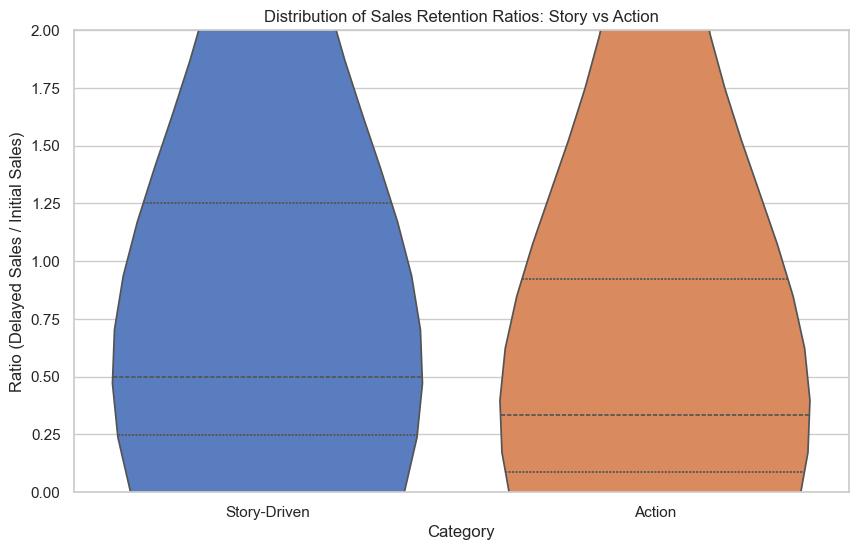

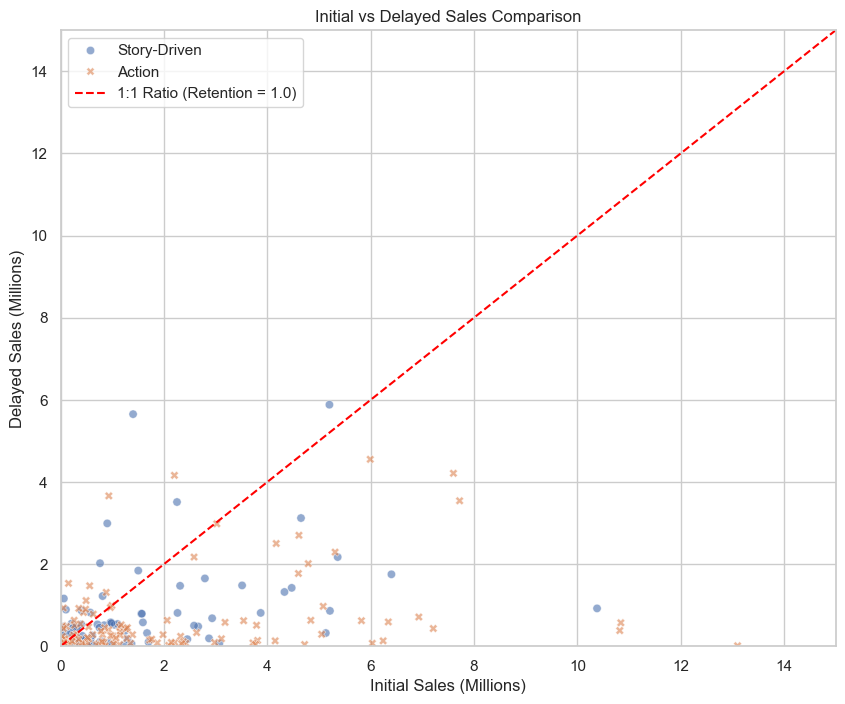

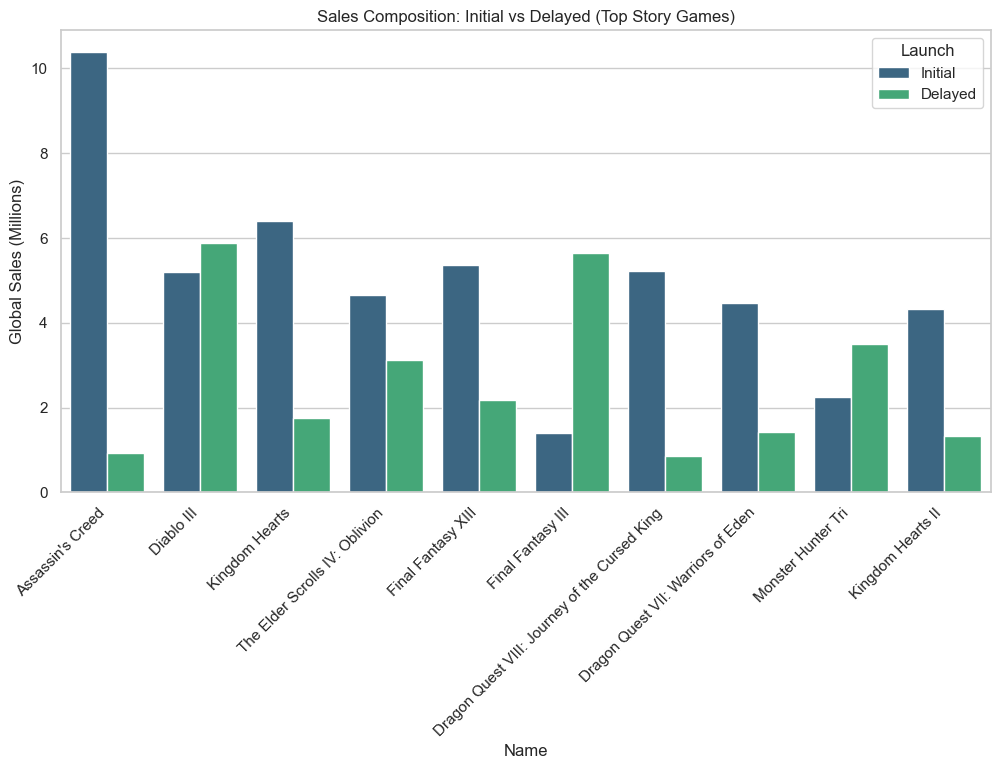

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Prepare Data for Visualizations
story_games = final_stats[final_stats['Genre'].isin(['Role-Playing', 'Adventure'])].copy()
story_games['Category'] = 'Story-Driven'

action_games = final_stats[final_stats['Genre'] == 'Action'].copy()
action_games['Category'] = 'Action'

comparison_df = pd.concat([story_games, action_games])

# --- Visualization 1: Violin Plot (Distribution) ---
# User requested "prettier" or easier to understand graphs than Box Plots.
# A Violin Plot shows the probability density of the data at different values.
plt.figure(figsize=(10, 6))
sns.violinplot(data=comparison_df, x='Category', y='Delayed_Ratio', palette='muted', inner='quartile')
plt.title('Distribution of Sales Retention Ratios: Story vs Action')
plt.ylabel('Ratio (Delayed Sales / Initial Sales)')
plt.ylim(0, 2) # Limit y-axis to see the main distribution clearly, ignoring extreme outliers
plt.show()

# --- Visualization 2: Scatter Plot (Growth vs Decay) ---
# This plots Initial Sales (x) vs Delayed Sales (y).
# Points ABOVE the diagonal line sold MORE in delayed release than initially (Growing).
plt.figure(figsize=(10, 8))
sns.scatterplot(data=comparison_df, x='Initial', y='Delayed', hue='Category', alpha=0.6, style='Category')

# Add a diagonal line (y=x) to represent 1:1 retention
plt.plot([0, 15], [0, 15], color='red', linestyle='--', label='1:1 Ratio (Retention = 1.0)')
plt.title('Initial vs Delayed Sales Comparison')
plt.xlabel('Initial Sales (Millions)')
plt.ylabel('Delayed Sales (Millions)')
plt.legend()
plt.xlim(0, 15)
plt.ylim(0, 15)
plt.show()

# --- Visualization 3: Top Story Games Split (Stacked Bar) ---
# Select top 10 story games by total sales
top_story = story_games.sort_values('Total_Sales', ascending=False).head(10)

# Melt for plotting
top_story_melt = top_story.melt(id_vars='Name', value_vars=['Initial', 'Delayed'], var_name='Launch', value_name='Sales')

plt.figure(figsize=(12, 6))
sns.barplot(data=top_story_melt, x='Name', y='Sales', hue='Launch', palette='viridis')
plt.title('Sales Composition: Initial vs Delayed (Top Story Games)')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Global Sales (Millions)')
plt.show()

## 13. Deep Dive: The "First Platform" Advantage

**Question:** Does the starting platform matter for the "Gradual Release" strategy? 
Are successful gradual releases typically timed exclusives starting on a major console (e.g., PS3/X360) and then moving to PC/Next-Gen?

Top Launch Types for Gradual Releases:
Launch_Type
Other/Mixed                  198
Gen 6 Console (PS2/XB/GC)    197
Gen 7 Console (PS3/X360)     138
Handheld                      86
PC Exclusive Start            45
Name: count, dtype: int64


C:\Users\PC\AppData\Local\Temp\ipykernel_4032\2758474282.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=gradual_platforms, x='Launch_Type', y='Total_Sales', palette='coolwarm', inner='quartile')


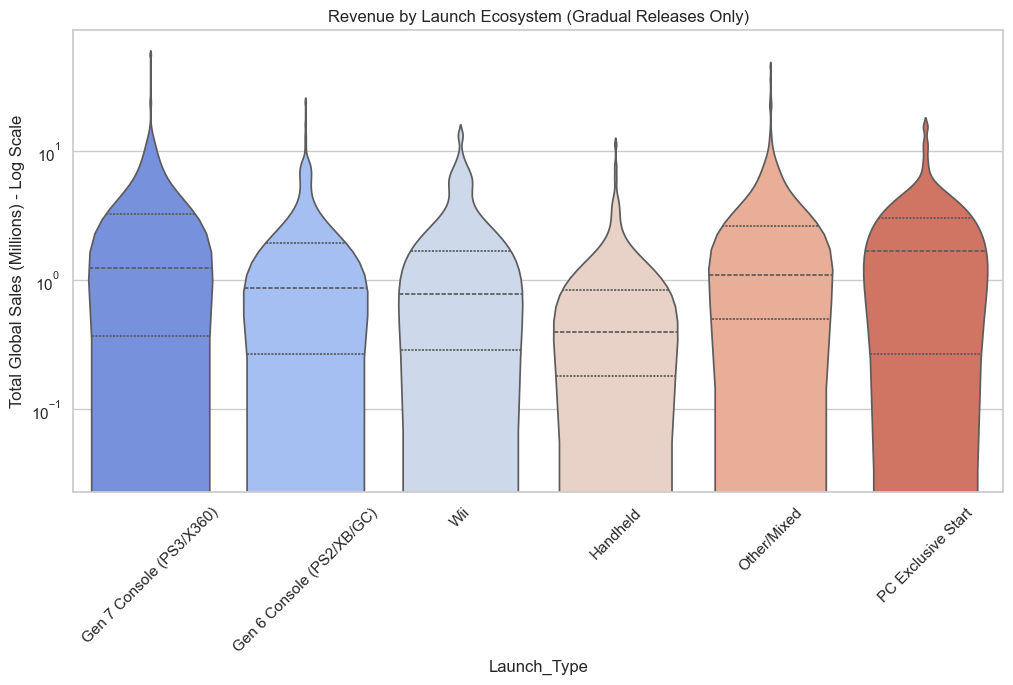

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Identify First Platform(s) for each game
# Logic: For each Name, select runs where Year == Min_Year

# FIX: Use 'multi_platform_games' which has the 'Strategy' column (game_stats does not)
game_min_years = multi_platform_games[['Name', 'Min_Year', 'Release_Span', 'Strategy', 'Total_Sales']].copy()

# Join with df_clean to get the platforms actually released in that Min_Year
launch_data = df_clean.merge(game_min_years, on='Name')
launch_data = launch_data[launch_data['Year'] == launch_data['Min_Year']]

# Aggregate platforms into a set/list (because a game might launch on PS3 & X360 same year)
first_platforms = launch_data.groupby('Name')['Platform'].apply(lambda x: sorted(list(set(x)))).reset_index()
first_platforms.rename(columns={'Platform': 'Launch_Platforms'}, inplace=True)

# Helper: Define "Launch Ecosystem"
def classify_launch(platforms):
    platforms_str = ",".join(platforms)
    if 'PS3' in platforms or 'X360' in platforms:
        return 'Gen 7 Console (PS3/X360)'
    elif 'PS2' in platforms or 'XB' in platforms or 'GC' in platforms:
        return 'Gen 6 Console (PS2/XB/GC)'
    elif 'PC' in platforms and len(platforms) == 1:
        return 'PC Exclusive Start'
    elif 'Wii' in platforms:
        return 'Wii'
    elif 'DS' in platforms or 'PSP' in platforms or 'GBA' in platforms:
        return 'Handheld'
    else:
        return 'Other/Mixed'

first_platforms['Launch_Type'] = first_platforms['Launch_Platforms'].apply(classify_launch)
first_platforms['Primary_Platform'] = first_platforms['Launch_Platforms'].apply(lambda x: x[0] if len(x) > 0 else 'Unknown')

# Merge back to the main analysis DataFrame
platform_analysis = game_min_years.merge(first_platforms, on='Name')

# Filter to Gradual only for this specific insight
gradual_platforms = platform_analysis[platform_analysis['Strategy'] == 'Gradual']

print("Top Launch Types for Gradual Releases:")
print(gradual_platforms['Launch_Type'].value_counts().head())

# Visualization: Sales by Launch Type
plt.figure(figsize=(12, 6))
sns.violinplot(data=gradual_platforms, x='Launch_Type', y='Total_Sales', palette='coolwarm', inner='quartile')
plt.yscale('log')
plt.title('Revenue by Launch Ecosystem (Gradual Releases Only)')
plt.ylabel('Total Global Sales (Millions) - Log Scale')
plt.xticks(rotation=45)
plt.show()

**Deep Dive Question:**
Does the *starting* ecosystem matter?
Is the success of the Gradual strategy driven purely by big console exclusives (e.g., *Red Dead Redemption*) that later come to PC?

**Visual Analysis:**
The Violin plot above breaks down Gradual revenue by the "First Platform" launched.

**Result:**
The data offers a surprise.
*   **PC Exclusive Starts** yield the **highest median sales (~1.68M)**, beating out the Gen 7 Console start (~1.25M).
*   This suggests that a "scale-up" strategy (building a community on PC, refining the game, then doing a massive Console launch) is a highly effective, under-appreciated path to revenue.